In [1]:
# 数値計算およびデータ分析用ライブラリ
import numpy as np  # 数値計算を効率的に行うためのライブラリ
import pandas as pd  # データ分析を容易にするためのライブラリ

# グラフ描画用ライブラリ
import matplotlib.pyplot as plt  # グラフ描画のためのライブラリ
from matplotlib.colors import ListedColormap  # カラーマップを作成するためのモジュール
import seaborn as sns  # グラフ描画用ライブラリ（Matplotlibをベースにした高水準インターフェース）

# 統計および信号処理関数用ライブラリ
from scipy import stats  # 統計関数を扱うモジュール
from scipy import signal  # 信号処理関数を扱うモジュール
from scipy.signal import savgol_filter  # Savitzky-Golayフィルターを適用するためのモジュール
from scipy.optimize import curve_fit  # カーブフィッティングを行うための関数
from scipy.special import wofz  # Faddeeva関数を計算するための関数

# 機械学習モデルおよび評価関数
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score  # データ分割、グリッドサーチ、クロスバリデーション
from sklearn.cross_decomposition import PLSRegression  # 部分最小二乗回帰モデル
from sklearn.svm import SVR, SVC  # サポートベクターマシン（回帰、分類）
from sklearn.pipeline import Pipeline  # パイプラインの作成
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report  # 評価指標
from sklearn.ensemble import IsolationForest, RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, GradientBoostingClassifier  # アンサンブル学習（外れ値検出、回帰、分類）
from sklearn.preprocessing import FunctionTransformer  # 関数変換器
from sklearn.decomposition import PCA  # 主成分分析
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # 線形判別分析
from sklearn.linear_model import LinearRegression  # 線形回帰

# その他のライブラリ
from tqdm import tqdm  # プログレスバー表示
import pickle  # オブジェクトの直列化・非直列化
from xgboost import XGBRegressor  # XGBoost回帰モデル


### <span style="color: DeepPink; ">7.1 スペクトルデータの読み込み</span> 

In [2]:
# NIRdata_chapt7 フォルダ内の spectra.csv ファイルのパスを指定
file_spe = 'dataChapter7/spectra.csv'
file_prop = 'dataChapter7/prop.csv'
# CSVファイルを読み込む。A列をカラム名、1行目をインデックス名とする
spectra = pd.read_csv(file_spe, index_col=0, header=0)
spectra=spectra.T
prop = pd.read_csv(file_prop, index_col=0, header=0)

In [3]:
# propというデータフレームの新しい列'label'を作成し、初期値としてNoneを設定
prop['label'] = None
# propデータフレームのインデックスが'Aga'で始まる行の'label'列に0を設定
prop.loc[prop.index.str.startswith('Aga'), 'label'] = 0
# propデータフレームのインデックスが'Kiri'で始まる行の'label'列に1を設定
prop.loc[prop.index.str.startswith('Kiri'), 'label'] = 1
# propデータフレームの'label'列のデータ型を整数型(int)に変換
prop['label'] = prop['label'].astype(int)
# propデータフレームの要約統計量を表示
prop.describe()

,mc,label
count,106.000000,106.000000
mean,50.780579,0.500000
std,19.649163,0.502375
min,0.000000,0.000000
25%,37.557799,0.000000
50%,54.073725,0.500000
75%,67.231813,1.000000
max,81.967213,1.000000


### <span style="color: DeepPink; ">7.2 箱ひげ図による目的変数の把握</span> 

箱ひげ図（Boxplot）は、データの分布を視覚的に表現するためのグラフで、以下のようなデータの特徴を可視化します：
- <span style="color: blue; ">中央値（Median)</span> <BR>
箱の中央にある線（または点）で、データの中央値を示します。データを半分に分ける値で、下半分と上半分の中央に位置します。
<BR><BR>
- <span style="color: blue; ">四分位範囲（Interquartile Range, IQR）</span><BR>
箱の上下の端は、第一四分位数（Q1、下側四分位数）と第三四分位数（Q3、上側四分位数）を示しており、これらの間の範囲（Q3 - Q1）を四分位範囲と呼びます。この範囲は、データの中央50%を含んでいます。
<BR><BR>
- <span style="color: blue; ">外れ値（Outliers）</span><BR>箱から離れた点としてプロットされ、通常、Q1またはQ3から1.5倍IQR以上離れた値として定義されます。外れ値は、データの分布における異常値や特異な値を示します。
<BR><BR>
- <span style="color: blue; ">最大値と最小値（Whiskers）</span><BR>箱の外側に伸びる線（ヒゲ）は、外れ値を除いたデータの最大値と最小値を示しています。ヒゲの長さは、データの散らばり具合を表しますが、外れ値の影響を受けにくい方法で計算されます。

In [4]:
def plot_boxplot_and_histogram(prop_data, bins=10):
    """
    データのボックスプロットとヒストグラムを表示する関数。

    Parameters:
    prop_data (array-like): プロットするデータ
    bins (int): ヒストグラムのビン数（デフォルトは10）

    Returns:
    None
    """
    plt.figure(figsize=(8, 5))

    # ボックスプロット
    plt.subplot(1, 2, 1)
    boxplot_dict = plt.boxplot(prop_data, whis=1.5, patch_artist=True)
    plt.title('Boxplot')

    # ヒストグラム
    plt.subplot(1, 2, 2)
    plt.hist(prop_data, bins=bins, color='blue', alpha=0.7)
    plt.title('Histogram')
    plt.tight_layout()
    plt.show()
    
    # 四分位数（Q1, Q3）とIQRの計算
    Q1 = np.percentile(prop_data, 25)
    Q3 = np.percentile(prop_data, 75)
    IQR = Q3 - Q1

    # 最大、最小の範囲
    whiskers = [item.get_ydata() for item in boxplot_dict['whiskers']]
    lower_whisker = whiskers[0][1]
    upper_whisker = whiskers[1][1]

    # 外れ値
    fliers = [item.get_ydata() for item in boxplot_dict['fliers']]
    outliers = fliers[0] if fliers else []  # 外れ値がない場合は空のリスト

    # 結果の出力
    print(f"Q1 (第一四分位数): {Q1}")
    print(f"Q3 (第三四分位数): {Q3}")
    print(f"IQR (四分位範囲): {IQR}")
    print(f"最小: {lower_whisker}")
    print(f"最大: {upper_whisker}")
    print(f"外れ値: {outliers}")

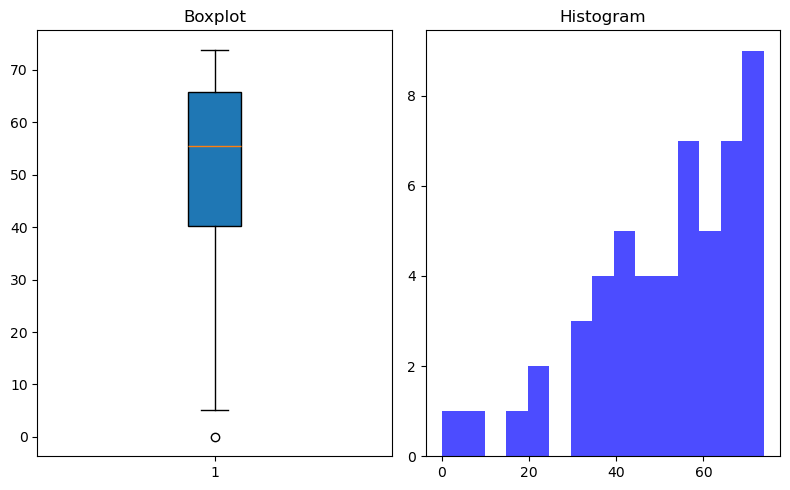

Q1 (第一四分位数): 40.32059186
Q3 (第三四分位数): 65.72133169
IQR (四分位範囲): 25.40073983
最小: 5.055487053
最大: 73.8594328
外れ値: [0.]


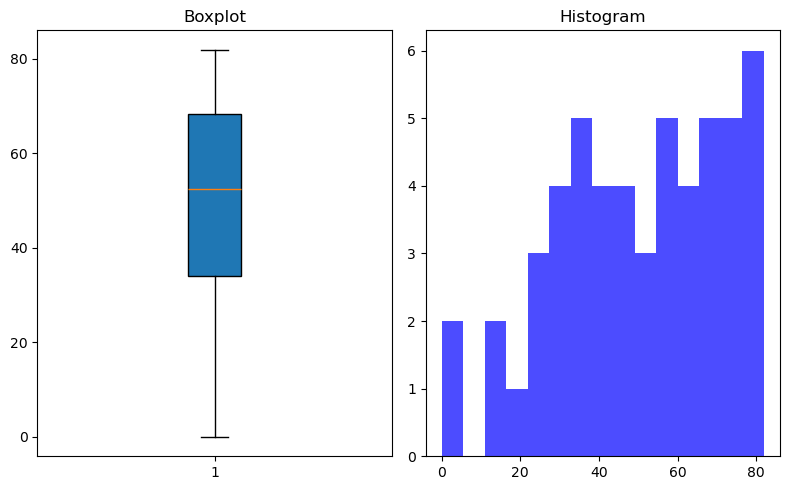

Q1 (第一四分位数): 34.01639344
Q3 (第三四分位数): 68.44262295
IQR (四分位範囲): 34.42622951
最小: 0.0
最大: 81.96721311
外れ値: []


In [5]:
mc_0 = prop[prop['label'] == 0]['mc']
mc_1 = prop[prop['label'] == 1]['mc']
plot_boxplot_and_histogram(mc_0, bins=15)
plot_boxplot_and_histogram(mc_1, bins=15)

### <span style="color: DeepPink; ">7.3 スペクトル表示</span> 

In [6]:
def plot_spectra(wave, spec):
    """
    スペクトルをプロットする関数。

    Parameters:
    wave (numpy.ndarray): 波長の配列
    spec (numpy.ndarray): 吸収スペクトルの配列（行がサンプル、列が波長）

    Returns:
    None
    """   

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(wave, spec.T)
    ax.set_xlabel('Wavelength')
    ax.set_ylabel('Absorbance')
    ax.set_title('Spectra')

    plt.show()

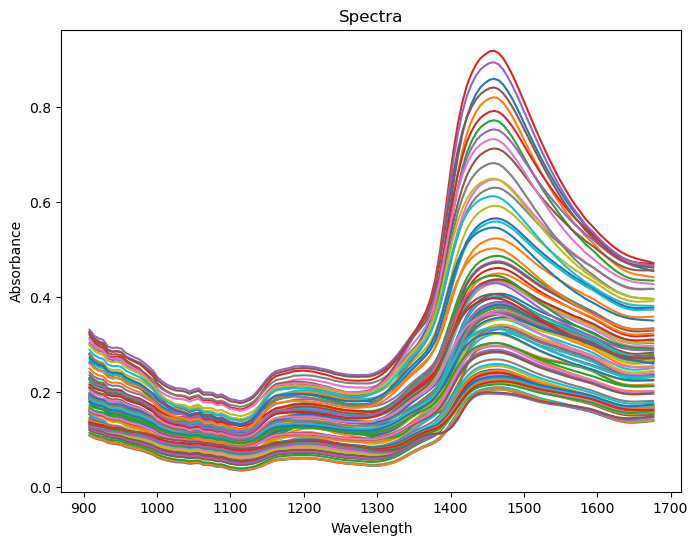

In [6]:
plot_spectra(spectra.columns, spectra)

### <span style="color: DeepPink; ">7.4 ピーク検出</span> 

In [7]:
# スペクトルデータからピークを検出する関数
def detect_peaks(wave, spec, num_smooth):
    """
    スペクトルデータからピークを検出し、プロットする関数。

    Parameters:
    wave (numpy.ndarray): 波長データ
    spec (numpy.ndarray or pandas.DataFrame): スペクトルデータ
    num_smooth (int): スペクトルデータを平滑化するための窓幅

    Returns:
    None
    """
    # スペクトルデータを配列に変換
    spec_array = spec.values if not isinstance(spec, np.ndarray) else spec

    #①スペクトルデータの2次微分を取得
    derispec_array = signal.savgol_filter(spec_array, num_smooth, 2, 2)

    #②元のスペクトルデータからピークを検出
    spec_peaks_posi, _ = signal.find_peaks(spec_array)

    #③2次微分スペクトルデータから負のピークを検出
    derispec_peaks_posi, _ = signal.find_peaks(-derispec_array)

    # 元のスペクトルデータとそのピークをプロット
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(wave, spec_array, color='cyan', label='Spectra')
    plt.plot(wave[spec_peaks_posi], spec_array[spec_peaks_posi], "o", label='Positive Peaks')
    for i, txt in enumerate(spec_peaks_posi):
        plt.text(wave[txt], spec_array[txt], f"{wave[txt]:.2f}", fontsize=8, verticalalignment='bottom')
    plt.title('Spectra and Positive Peaks')
    plt.xlabel('Wavelength')
    plt.legend()

    # 二次微分スペクトルとその負のピークをプロット
    plt.subplot(2, 1, 2)
    plt.plot(wave, derispec_array, color='cyan', label='Derispec')
    plt.plot(wave[derispec_peaks_posi], derispec_array[derispec_peaks_posi], "o", label='Negative Peaks')
    for i, txt in enumerate(derispec_peaks_posi):
        plt.text(wave[txt], derispec_array[txt], f"{wave[txt]:.2f}", fontsize=8, verticalalignment='bottom')
    plt.title('Derispec and Negative Peaks')
    plt.xlabel('Wavelength')
    plt.legend()
    plt.show()


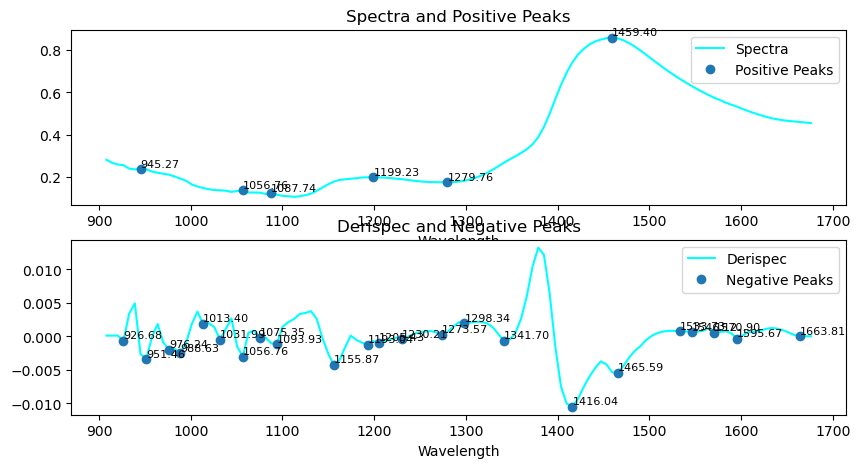

In [8]:
detect_peaks(spectra.columns,spectra.iloc[0,:],5)

### <span style="color: DeepPink; ">7.5 相関係数スペクトル</span> 

In [10]:
def plot_correlation_spectrum(wave, spec, num_smooth, propdata):
    """
    スペクトルデータと目的変数の相関スペクトルをプロットする関数。

    Parameters:
    wave (numpy.ndarray): 波長データ
    spec(pandas.DataFrame): スペクトルデータ
    num_smooth (int): 平滑化のための窓幅
    propdata (numpy.ndarray): 目的変数（プロパティ）データ

    Returns:
    numpy.ndarray: 二次微分スペクトルと目的変数の相関係数
    """
    # スペクトルデータの二次微分を計算
    derispec = signal.savgol_filter(spec, num_smooth, 2, 2)
    
    #①各波長における吸光度スペクトルと目的変数の相関係数を計算
    spec_corr = np.array([np.corrcoef(spec.iloc[:, i], propdata)[0, 1] for i in range(spec.shape[1])])
    
    #②各波長における二次微分スペクトルと目的変数の相関係数を計算
    derispec_corr = np.array([np.corrcoef(derispec[:, i], propdata)[0, 1] for i in range(derispec.shape[1])])
    
    # 相関スペクトルをプロット
    plt.figure(figsize=(10, 8))
    
    # 吸光度スペクトルと目的変数との相関スペクトルをプロット
    plt.subplot(4, 1, 1)
    plt.plot(wave, spec.T, label='Spectra')
    
    plt.subplot(4, 1, 2)
    plt.plot(wave, spec_corr)
    plt.title('Correlation Spectrum for Spectra')
    plt.xlabel('Wavelength')
    plt.ylabel('Correlation Coefficient')
    plt.ylim(-1, 1)
    plt.legend()
    
    # 二次微分スペクトルと目的変数との相関スペクトルをプロット
    plt.subplot(4, 1, 3)
    plt.plot(wave, derispec.T, label='Derispectra')
    
    plt.subplot(4, 1, 4)
    plt.plot(wave, derispec_corr)  # 二次微分スペクトルの波長調整
    plt.title('Correlation Spectrum for Derispectra')
    plt.xlabel('Wavelength')
    plt.ylabel('Correlation Coefficient')
    plt.ylim(-1, 1)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    return derispec_corr


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


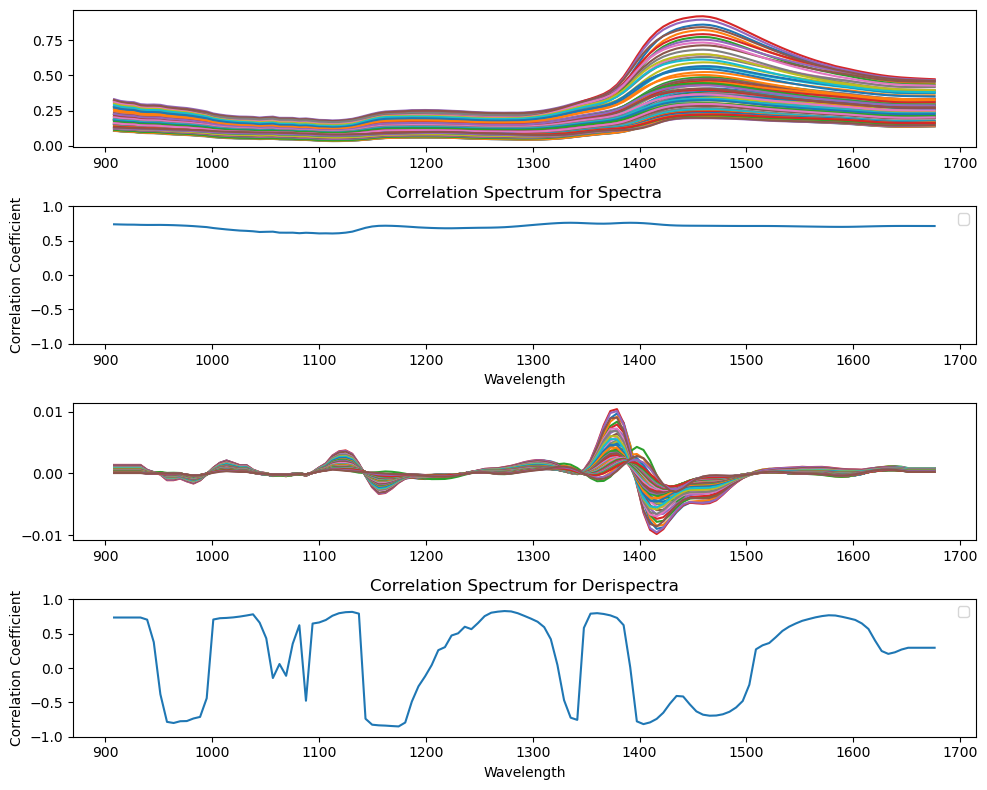

In [11]:
derispec_corr=plot_correlation_spectrum(spectra.columns,spectra,9,prop["mc"])

### <span style="color:DeepPink; ">7.6 ベースライン補正</span> 

In [12]:
def baseline_shift(wave, spec, wave1, wave2):
    """
    スペクトルデータのベースライン補正を行い、補正後のスペクトルデータの面積を計算する関数。

    Parameters:
    wave (numpy.ndarray): 波長データ
    spec (pandas.DataFrame): スペクトルデータ
    wave1 (float): ベースライン補正の開始波長
    wave2 (float): ベースライン補正の終了波長

    Returns:
    numpy.ndarray: ベースライン補正後の波長データ
    pandas.DataFrame: ベースライン補正後のスペクトルデータ
    pandas.Series: ベースライン補正後のスペクトルデータの面積
    """
    # 指定された2つの波長に最も近い波長のインデックスを見つける
    wave1_col = np.abs(wave - wave1).argmin()
    wave2_col = np.abs(wave - wave2).argmin()

    # 1次関数の傾きと切片を計算
    slope = (spec.iloc[:, wave2_col] - spec.iloc[:, wave1_col]) / (wave[wave2_col] - wave[wave1_col])
    intercept = spec.iloc[:, wave1_col] - slope * wave[wave1_col]

    # スペクトルデータのコピーを作成し、ベースライン補正を実行
    shifted_spec = spec.copy()
    for ind in range(len(spec)):
        shifted_spec.iloc[ind, wave1_col:wave2_col + 1] = spec.iloc[ind, wave1_col:wave2_col + 1] - \
                                                          (slope.iloc[ind] * wave[wave1_col:wave2_col + 1] + intercept.iloc[ind])

    # ベースライン補正後のスペクトルデータの抽出
    shifted_spec = shifted_spec.iloc[:, wave1_col:wave2_col + 1]
    shifted_wave = wave[wave1_col:wave2_col + 1]

    # ベースライン補正後のスペクトルデータの面積を計算
    integ_spec = shifted_spec.sum(axis=1)
    
    # 元のスペクトル、ベースライン補正後のスペクトル、スペクトルの面積をプロット
    plt.figure(figsize=(10, 10))
    
    plt.subplot(3, 1, 1)
    plt.plot(wave, spec.T)
    plt.xlabel('Wavelength')
    plt.ylabel('Absorbance')
    plt.title('Spectra')

    plt.subplot(3, 1, 2)
    plt.plot(shifted_wave, shifted_spec.T)
    plt.xlabel('Wavelength')
    plt.ylabel('Absorbance')
    plt.title('Shifted Spectra')

    plt.subplot(3, 1, 3)
    plt.scatter(range(1, len(integ_spec) + 1), integ_spec)
    plt.xlabel('Sample Number')
    plt.ylabel('Integrated Absorbance')
    plt.title('Integrated Spectra')

    plt.tight_layout()
    plt.show()
    
    return shifted_wave, shifted_spec, integ_spec


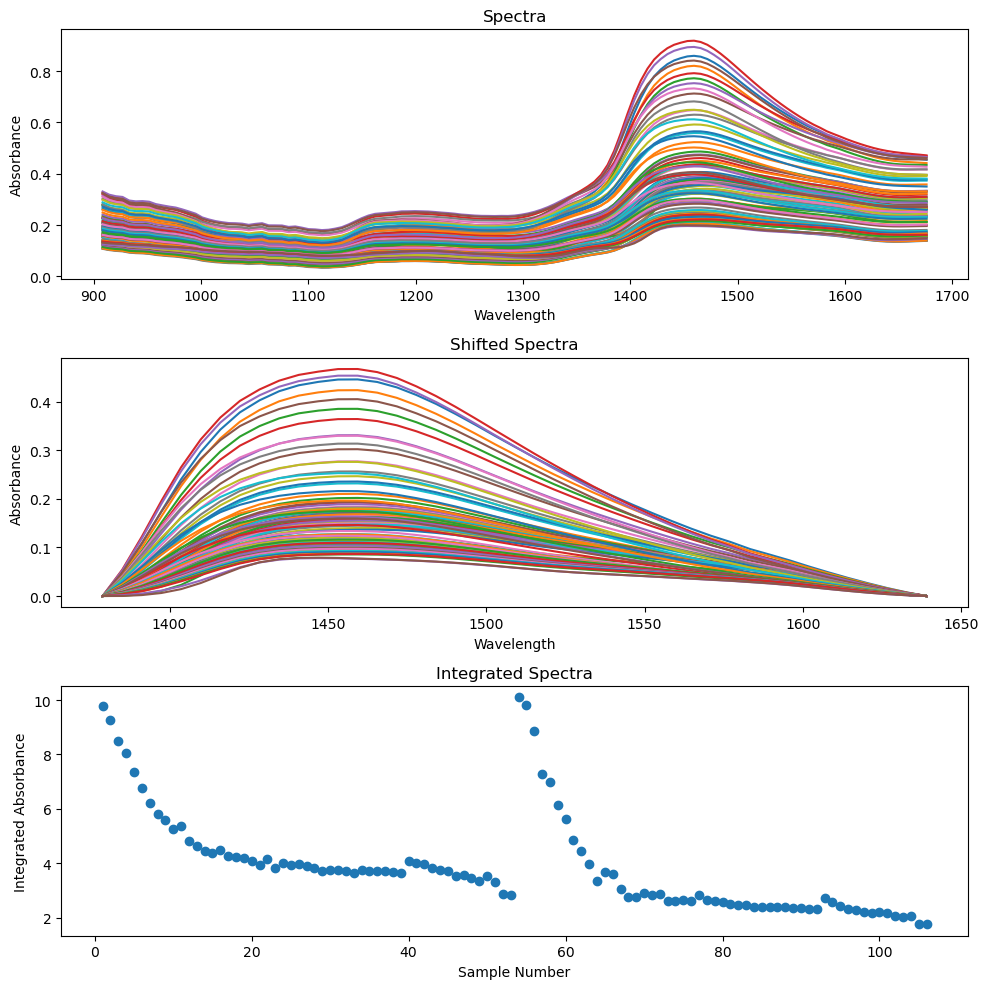

In [13]:
shifted_wave,shifted_spec,integ_spec=baseline_shift(spectra.columns,spectra,1381,1641)

### <span style="color:DeepPink; ">7.7 カーブフィッティング</span> 

### <span style="color: blue; ">ピーク波長の特定</span> 

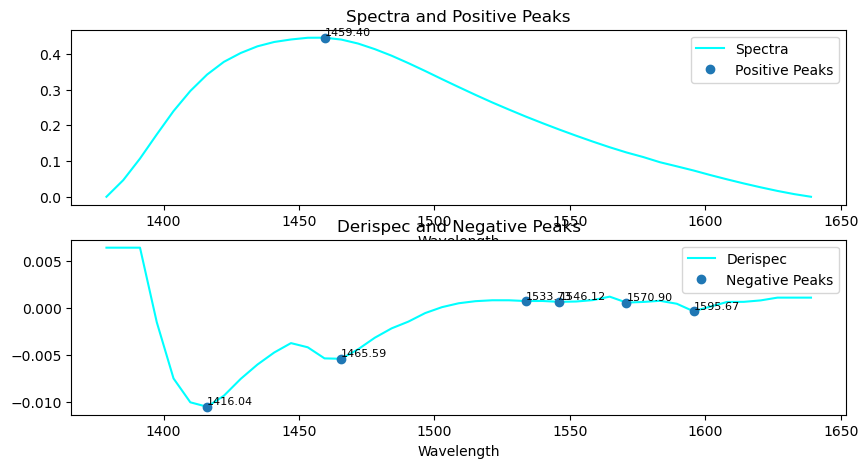

In [14]:
detect_peaks(shifted_wave,shifted_spec.iloc[0,:],5)

### <span style="color: blue; ">関数の定義と利用</span> 

In [15]:
# ①Voigt関数の定義
def voigt(x, amplitude, mean, sigma, gamma):
    z = ((x - mean) + 1j * gamma) / (sigma * np.sqrt(2))
    return amplitude * np.real(wofz(z)) / (sigma * np.sqrt(2 * np.pi))

# ②2つのVoigt関数の合成
def voigt_double(x, amp1, mean1, sigma1, gamma1, amp2, mean2, sigma2, gamma2):
    return voigt(x, amp1, mean1, sigma1, gamma1) + voigt(x, amp2, mean2, sigma2, gamma2)

# 2つのVoigt関数でフィッティングする関数
def fit_voigt_double(wavelength, spec, initial_peak_positions):
    """
    スペクトルデータにVoigt関数を2つフィッティングし、ピーク位置、面積、半値全幅を計算する関数。
    Parameters:
    wavelength (numpy.ndarray): 波長データ
    spec (numpy.ndarray): スペクトルデータ（各行が1つのスペクトル）
    initial_peak_positions (list): ピーク位置の初期値のリスト

    Returns:
    list: フィッティング結果のリスト（各要素はピーク位置、面積、半値全幅のタプル）
    """
    results = []
    plt.figure(figsize=(12, 8))
    
    # ③各スペクトルに対してフィッティングを行う
    for i, specs in enumerate(tqdm(spec, desc="Fitting progress")):
        max_index1 = np.argmin(np.abs(wavelength - initial_peak_positions[0]))
        max_index2 = np.argmin(np.abs(wavelength - initial_peak_positions[1]))
        initial_guess = [specs[max_index1], initial_peak_positions[0], 100, 1, specs[max_index2], initial_peak_positions[1], 100, 1]

        #④パラメータの下限と上限を設定
        lower_bounds = [0, wavelength[0], 0, 0, 0, wavelength[0], 0, 0]
        upper_bounds = [np.inf, wavelength[-1], np.inf, np.inf, np.inf, wavelength[-1], np.inf, np.inf]

        #⑤curve_fitでフィッティングを実行
        popt, pcov = curve_fit(voigt_double, wavelength, specs, p0=initial_guess, bounds=(lower_bounds, upper_bounds))

        perr = np.sqrt(np.diag(pcov))

        # フィッティング結果からピーク位置、面積、半値全幅を計算
        peak_position1 = popt[1]
        peak_position2 = popt[5]
        area1 = popt[0] * (np.sqrt(2 * np.pi) * np.abs(popt[2]) + 2 * np.abs(popt[3]))
        area2 = popt[4] * (np.sqrt(2 * np.pi) * np.abs(popt[6]) + 2 * np.abs(popt[7]))
        fwhm1 = 2 * np.sqrt(2 * np.log(2)) * (np.abs(popt[2]) + np.abs(popt[3]))
        fwhm2 = 2 * np.sqrt(2 * np.log(2)) * (np.abs(popt[6]) + np.abs(popt[7]))

        results.append((peak_position1, area1, fwhm1, peak_position2, area2, fwhm2, perr))
        
        # 最初のスペクトルとフィッティング結果をプロット
        if i == 0:
            plt.subplot(4, 2, 1)
            plt.plot(wavelength, specs, 'k-', label='Original Spectrum')
            plt.plot(wavelength, voigt(wavelength, popt[0], popt[1], popt[2], popt[3]), 'm--', label='Voigt Fit 1')
            plt.plot(wavelength, voigt(wavelength, popt[4], popt[5], popt[6], popt[7]), 'c--', label='Voigt Fit 2')
            plt.plot(wavelength, voigt_double(wavelength, *popt), 'r--', label='Double Voigt Fit')
            plt.xlabel('Wavelength')
            plt.ylabel('Absorbance')
            plt.legend()
    
    # フィッティング結果のプロット
    sample_numbers = range(1, len(results) + 1)
    peak_positions1 = [result[0] for result in results]
    peak_positions2 = [result[3] for result in results]
    areas1 = [result[1] for result in results]
    areas2 = [result[4] for result in results]
    fwhms1 = [result[2] for result in results]
    fwhms2 = [result[5] for result in results]
    errors = [np.mean(result[6]) for result in results]

    plt.subplot(4, 2, 3)
    plt.scatter(sample_numbers, peak_positions1, c='m')
    plt.xlabel('Sample Number')
    plt.ylabel('Peak Position 1')

    plt.subplot(4, 2, 4)
    plt.scatter(sample_numbers, peak_positions2, c='c')
    plt.xlabel('Sample Number')
    plt.ylabel('Peak Position 2')

    plt.subplot(4, 2, 5)
    plt.scatter(sample_numbers, areas1, c='m')
    plt.xlabel('Sample Number')
    plt.ylabel('Area 1')

    plt.subplot(4, 2, 6)
    plt.scatter(sample_numbers, areas2, c='c')
    plt.xlabel('Sample Number')
    plt.ylabel('Area 2')

    plt.subplot(4, 2, 7)
    plt.scatter(sample_numbers, fwhms1, c='m')
    plt.xlabel('Sample Number')
    plt.ylabel('FWHM 1')

    plt.subplot(4, 2, 8)
    plt.scatter(sample_numbers, fwhms2, c='c')
    plt.xlabel('Sample Number')
    plt.ylabel('FWHM 2')

    plt.subplot(4, 2, 2)
    plt.scatter(sample_numbers, errors, c='k')
    plt.xlabel('Sample Number')
    plt.ylabel('Average Fitting Error')

    plt.tight_layout()
    plt.show()   
    return results


Fitting progress: 100%|██████████████████████████████████████████████████████████████| 106/106 [00:04<00:00, 25.98it/s]


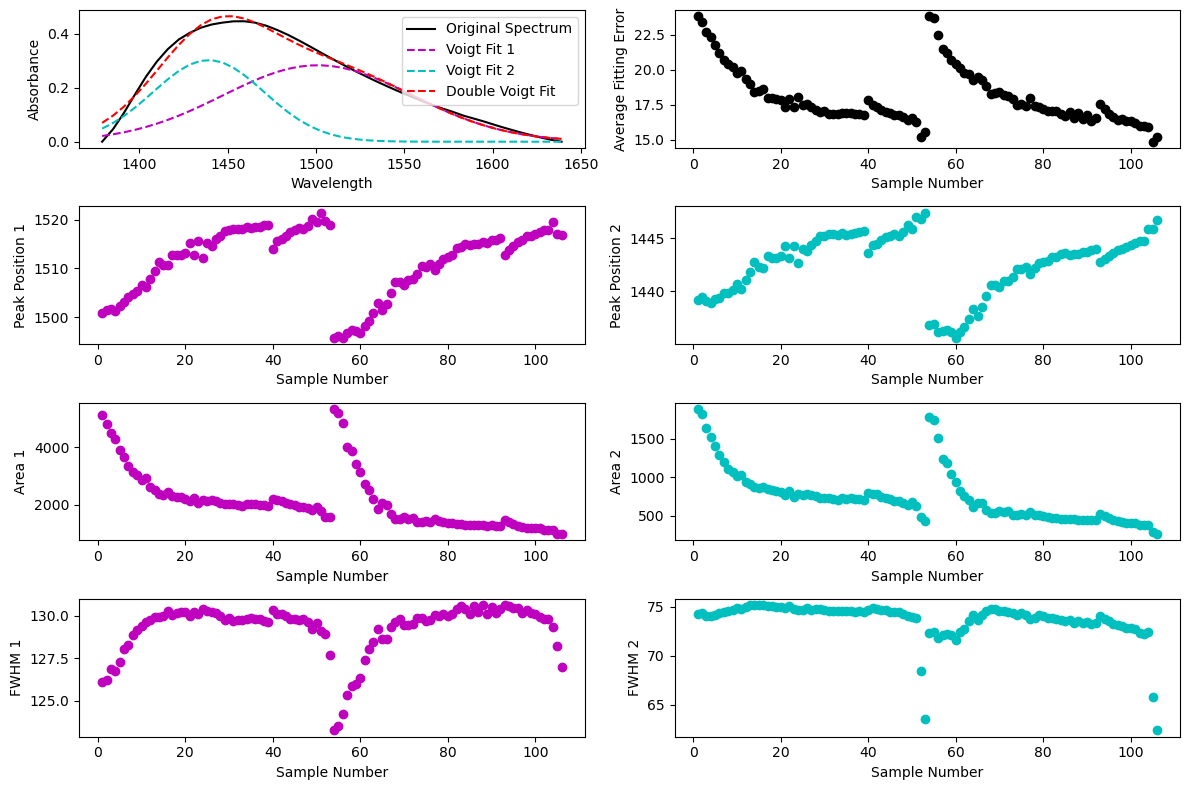

In [16]:
fit_results =  fit_voigt_double(shifted_wave, shifted_spec.values,[1410,1450])

### <span style="color:DeepPink; ">7.8 アウトライヤー検出</span> 

In [17]:
def remove_outliers_and_plot(spec, prop_data, contamination):
    """
    スペクトルデータと目的変数に対してIsolation Forestを適用し、アウトライヤーを除去した後、
    散布図とPCAローディングをプロットする関数。

    Parameters:
    spec (pandas.DataFrame): スペクトルデータ
    prop_data (pandas.Series): 目的変数
    contamination (float or 'auto'): アウトライヤーの割合または'auto'を指定

    Returns:
    None
    """
    #①主成分分析 (PCA) を適用して次元削減
    pca = PCA(n_components=4)  # 最初の4つの主成分を取得
    spectra_pca = pca.fit_transform(spec)

    #②Isolation Forestモデルを作成して適用 (スペクトルデータ)
    model_spec = IsolationForest(contamination=contamination, random_state=0)
    predict_spec = model_spec.fit_predict(spectra_pca)

    #③Isolation Forestモデルを作成して適用 (目的変数)
    model_prop = IsolationForest(contamination=contamination, random_state=0)
    predict_prop = model_prop.fit_predict(prop_data.values.reshape(-1, 1))

    #④アウトライヤーと判断されたサンプルのインデックスを取得
    outlier_idx_spec = np.where(predict_spec == -1)[0]
    outlier_idx_prop = np.where(predict_prop == -1)[0]
    outlier_idx = np.union1d(outlier_idx_spec, outlier_idx_prop)
    print("スペクトルからのアウトライヤーは",outlier_idx_spec)
    print("目的変数からのアウトライヤーは",outlier_idx_prop)
    
    # アウトライヤーを除去したスペクトルデータと目的変数を返す
    spectra_isolated = spec.iloc[predict_spec == 1, :]
    prop_isolated = prop_data.iloc[predict_prop == 1]
    # プロット (散布図)
    plt.figure(figsize=(6,6))
    plt.subplot(3, 1, 1)
    plt.scatter(range(len(prop_data)), prop_data, color='black', label='Normal')
    plt.scatter(outlier_idx, prop_data.iloc[outlier_idx], color='red', label='Outlier')
    plt.xlabel('Sample Number')
    plt.ylabel('Property')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.scatter(spectra_pca[:, 0], spectra_pca[:, 1], color='black', label='Normal')
    plt.scatter(spectra_pca[outlier_idx, 0], spectra_pca[outlier_idx, 1], color='red', label='Outlier')
    plt.xlabel('PC1 Score')
    plt.ylabel('PC2 Score')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.scatter(spectra_pca[:, 2], spectra_pca[:, 3], color='black', label='Normal')
    plt.scatter(spectra_pca[outlier_idx, 2], spectra_pca[outlier_idx, 3], color='red', label='Outlier')
    plt.xlabel('PC3 Score')
    plt.ylabel('PC4 Score')
    plt.legend()

    # プロット (PCAローディング)
    plt.figure(figsize=(8, 4))
    loadings = pca.components_
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.plot(loadings[i, :])
        plt.title(f'PC{i + 1} Loadings')
        plt.xlabel('Wavelength Index')
        plt.ylabel('Loading Value')
            # プロット (PCAローディング)
    
    plt.figure(figsize=(8, 4))
    for i in range(4):
        plt.subplot(2, 2, i + 1)
        plt.scatter(spectra_pca[:, i],prop_data, color='black', label='Normal')
        plt.scatter(spectra_pca[outlier_idx, i], prop_data.iloc[outlier_idx], color='red', label='Outlier')
        plt.title(f'PC{i + 1} score vs prop')
        plt.xlabel('score')
        plt.ylabel('prop')

    plt.tight_layout()
    plt.show()
    return spectra_isolated,prop_isolated

スペクトルからのアウトライヤーは [  0   1  52  53  54 105]
目的変数からのアウトライヤーは [ 51  52  53  54 104 105]


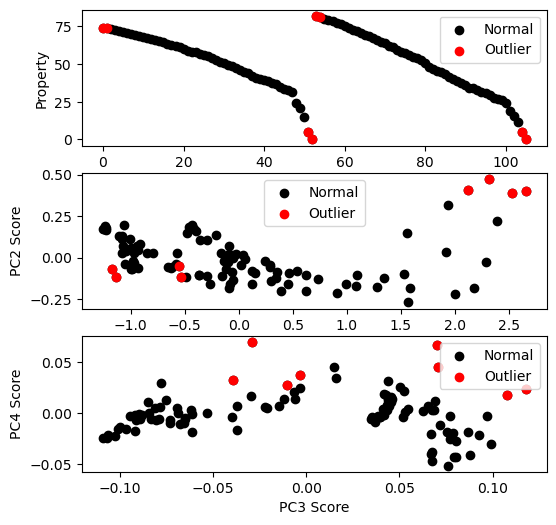

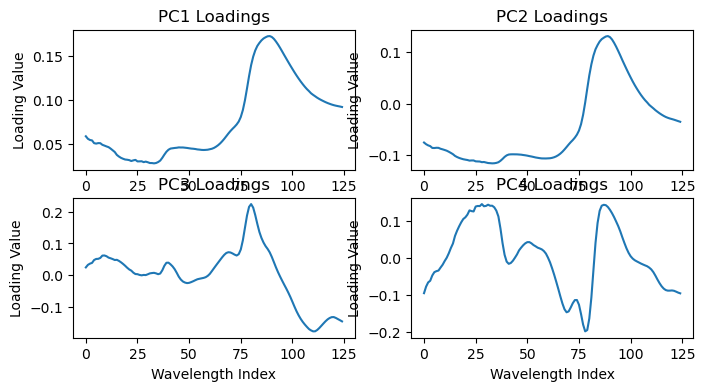

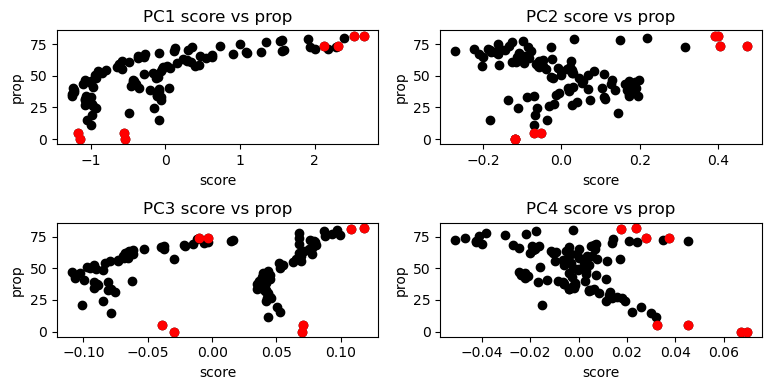

In [18]:
spectra_isolated,prop_isolated=remove_outliers_and_plot(spectra, prop["mc"], contamination=0.05)

### <span style="color:DeepPink; ">7.9 ヒートマップによるスペクトル表示</span> 

In [19]:
def plot_spectra_heatmap(wave,spec,vmin=None, vmax=None):
    """
    スペクトルデータをプロットとヒートマップで表示する関数。

    Parameters:
    wave (pandas.Index or list): 波長データ
    spec (pandas.DataFrame): スペクトルデータ（行が試料、列が波長）
    vmin (float, optional): ヒートマップの最小値
    vmax (float, optional): ヒートマップの最大値

    Returns:
    None
    """
    plt.figure(figsize=(10, 5))
    plt.subplot(2, 1, 1)
    plt.plot(wave,spec.T)
    plt.xlabel('Wavelength')
    plt.ylabel('spectra')
    plt.title('Spectra')

    # ヒートマップの作成
    plt.subplot(2, 1, 2)
    sns.heatmap(spec, cmap='RdBu_r', vmin=vmin, vmax=vmax, yticklabels=False, 
                cbar_kws={'label': 'Absorbance'}, xticklabels=[])
    #二次微分ようにcmap='RdBu_r'を用いているがIR等ではcmap='Reds'がおすすめです
    plt.xlabel('Wavelength')
    plt.ylabel('Sample')


    plt.show()

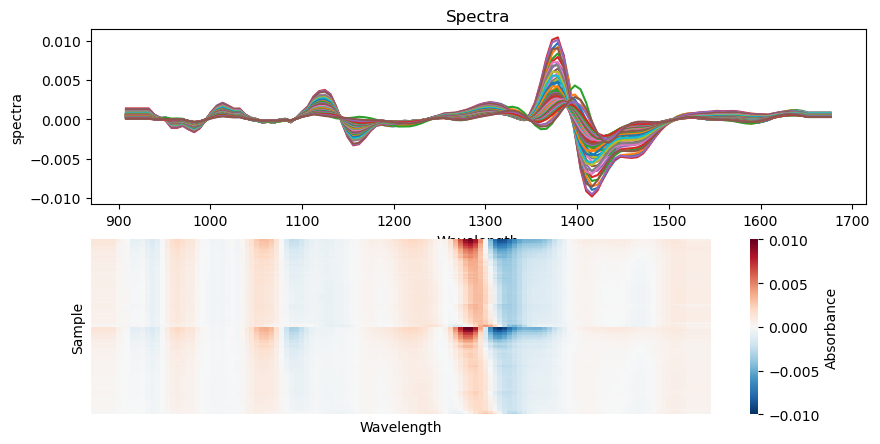

In [20]:
derispec = signal.savgol_filter(spectra,9, 2, 2)
plot_spectra_heatmap(spectra.columns,derispec,-0.01,0.01)

### <span style="color:DeepPink; ">7.10 各モジュールでの標準化自由度</span> 

In [21]:
#pandasで標準化スペクトル計算
spectra_std_pd = (spectra - spectra.mean()) / spectra.std(ddof=0)
#numpyで標準化スペクトル計算
spectra_array=spectra.values
spectra_std_np = (spectra_array - np.mean(spectra_array, axis=0)) / np.std(spectra_array, axis=0, ddof=0)
#StandardScalerで標準化スペクトル計算
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
spectra_std_scaler = scaler.fit_transform(spectra_array)
#それぞれが同じか確認（最初の行の、最初の複数列）
print(spectra_std_pd.iloc[0,:5])
print(spectra_std_np[0,:5])
print(spectra_std_scaler[0,:5])

908.100000    1.457256
914.294355    1.404202
920.488710    1.376664
926.683065    1.365333
932.877419    1.288476
Name: Aga1, dtype: float64
[1.45725553 1.40420156 1.37666445 1.3653331  1.28847642]
[1.45725553 1.40420156 1.37666445 1.3653331  1.28847642]


### <span style="color:DeepPink; ">7.11 PLSウェイトローディング、ローディング、回帰係数</span> 

In [22]:
pls=PLSRegression(n_components=5)
pls.fit(spectra,prop["mc"])

PLSRegression(n_components=5)

### <span style="color: blue; ">ウェイトローディングとローディング</span> 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


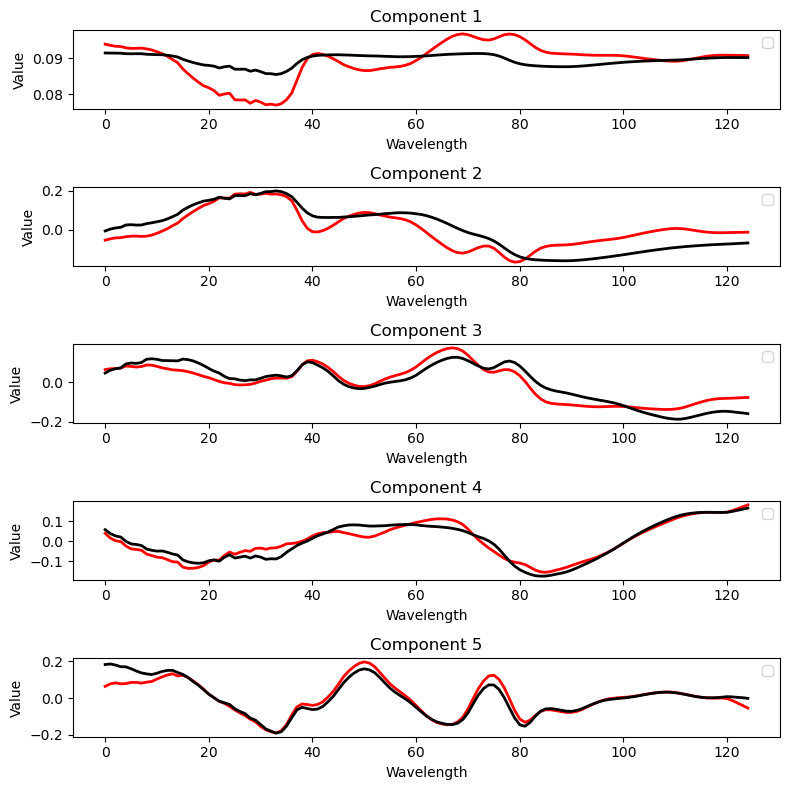

In [23]:
weight=pls.x_weights_ #ウェイトローディング 直交規格化されている
loading=pls.x_loadings_ #ローディング　直交規格化されていない
fig, axes = plt.subplots(5, 1, figsize=(8,8))
for i in range(5):
    axes[i].plot(weight[:, i], 'r-', linewidth=2)  # 赤がウェイトローディング
    axes[i].plot(loading[:, i], 'k-', linewidth=2)       # 黒がローディング
    axes[i].set_title(f'Component {i + 1}')
    axes[i].set_xlabel('Wavelength')
    axes[i].set_ylabel('Value')
    axes[i].legend()
plt.tight_layout()
plt.show()

### <span style="color: blue; ">回帰係数からの予測値算出</span> 

In [24]:
spectra_std_pd = (spectra - spectra.mean()) / spectra.std(ddof=1)#標準化スペクトル算出(ddof=1)
mc_mean=np.mean(prop["mc"])#含水率の平均値
regression=pls.coef_#回帰係数抽出（目的変数の標準偏差が掛けられたもの）
pred_cal=np.dot(spectra_std_pd ,regression.T)#スペクトルと回帰係数の内積
pred_cal=pred_cal+mc_mean#含水率平均値を足す
pred=pls.predict(spectra)#メソッドを用いて予測
print(pred[:6].T)
print(pred_cal[:6].T)

[[82.31229652 74.26720683 76.6284795  70.79490476 68.23411422 74.49967302]]
[[82.31229652 74.26720683 76.6284795  70.79490476 68.23411422 74.49967302]]


### <span style="color:DeepPink; ">7.11 ウェイトローディングと説明分散</span> 

In [25]:
def pls_cv_check(spec, prop_data, n_folds=5, max_components=10, scaleset=True):
    """
    PLS回帰を用いてクロスバリデーションを行い、スペクトルデータと目的変数の関係を評価します。
    各PLS成分数について、訓練データとクロスバリデーションのR2スコア、スペクトルおよび目的変数の寄与率、
    およびローディングを計算します。

    Parameters:
    spec (pandas.DataFrame): スペクトルデータ（行が試料、列が波長）
    prop_data (pandas.Series): 目的変数
    n_folds (int): クロスバリデーションの分割数
    max_components (int): 試行する最大のPLS成分数
    scaleset (bool): スペクトルデータを標準化するかどうか

    Returns:
    dict: 結果をまとめた辞書
    """
    scores_cv = []
    scores_train = []
    explained_var_spec = []
    explained_var_prop = []
    coefficients = []
    pred = []

    # スペクトルデータの標準化(scalesetがFalseの場合は中心化)
    if scaleset:
        spec_normalized = (spec - spec.mean()) / spec.std(ddof=1)
    else:
        spec_normalized = spec - spec.mean()

    #①PLSファクター数を増やしながら計算
    for n in range(1, max_components + 1):     
        pls = PLSRegression(n_components=n, scale=scaleset)
        score_cv = cross_val_score(pls, spec, prop_data, cv=n_folds, scoring='r2').mean()#②crossvalidationの決定係数算出
        pls.fit(spec, prop_data)
        score_train = pls.score(spec, prop_data)#③trainすべて使った場合の決定係数算出
        scores_cv.append(score_cv)#④appendで追加していく
        scores_train.append(score_train)
        #⑤PCAスコア算出（引数はspec）
        transformed_spec = pls.transform(spec)
        #⑥PCAスコアの分散合計/元のスペクトルの分散合計＝スペクトル寄与率
        explained_var_spec.append(np.var(transformed_spec, axis=0).sum() / np.var(spec_normalized, axis=0).sum())
        #⑦予測値算出（引数はspec）
        predicted = pls.predict(spec)
        #⑧予測値の分散合計/目的変数の分散合計＝目的変数寄与率
        explained_var_prop.append(np.var(predicted, axis=0).sum() / np.sum(np.var(prop_data, axis=0)))
        #⑨各PLSファクターにおける回帰係数を保存
        coefficients.append(pls.coef_)
        #⑩各PLSファクターにおける予測値を保存
        pred.append(predicted)

    optimal_n = np.argmax(scores_cv) + 1
    loadings = pls.x_loadings_
    weights = pls.x_weights_
    print("最適ファクター数は",optimal_n)
    #⑪各重要なパラメーターを辞書として出力
    results = {
        'optimal_n_components': optimal_n,
        'pred_value': pred,
        'r2_scores_train': scores_train,
        'r2_scores_cv': scores_cv,
        'explained_variances_spec': explained_var_spec,
        'explained_variances_prop': explained_var_prop,
        'loadings': loadings,
        'weights': weights,
        'regression_coefficients': coefficients
    }

    # 図の作成
    plt.figure(figsize=(8, 8))

    # スペクトルのプロット
    plt.subplot(3, 2, 1)
    plt.plot(spec.columns, spec_normalized.T, color='k', linewidth=0.5)
    plt.xlabel('Wavelength')
    plt.ylabel('Normalized Absorbance')
    plt.title('Normalized Spectra')

    # PLS因子数とR2スコアの関係
    plt.subplot(3, 2, 3)
    plt.plot(range(1, max_components + 1), scores_train, 'k-o', label='Train')
    plt.plot(range(1, max_components + 1), scores_cv, 'r-o', label='CV')
    plt.xlabel('Number of PLS Components')
    plt.ylabel('R2 Score')
    plt.title('PLS Components vs R2 Score')
    plt.legend()
    
    # PLS因子数と寄与率の関係
    plt.subplot(3, 2, 5)
    plt.plot(range(1, max_components + 1), explained_var_spec, 'm-o', label='Spectra')
    plt.plot(range(1, max_components + 1), explained_var_prop, 'c-o', label='Property')
    plt.xlabel('Number of PLS Components')
    plt.ylabel('Explained Variance')
    plt.title('PLS Components vs Explained Variance')
    plt.legend()

    # ローディングのプロット（コンポーネント1-3）
    plt.subplot(3, 2, 2)
    for i in range(3):
        plt.plot(spec.columns, weights[:, i], label=f'Component {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Loading')
    plt.title('Loadings (Components 1-3)')
    plt.legend()

    # ローディングのプロット（コンポーネント4-6）
    plt.subplot(3, 2, 4)
    for i in range(3, 6):
        plt.plot(spec.columns, weights[:, i], label=f'Component {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Loading')
    plt.title('Loadings (Components 4-6)')
    plt.legend()

    # ローディングのプロット（コンポーネント7-10）
    plt.subplot(3, 2, 6)
    for i in range(6, 10):
        plt.plot(spec.columns, weights[:, i], label=f'Component {i + 1}')
    plt.xlabel('Wavelength')
    plt.ylabel('Loading')
    plt.title('Loadings (Components 7-10)')
    plt.legend()

    plt.tight_layout()
    plt.show()

    return results

最適ファクター数は 8


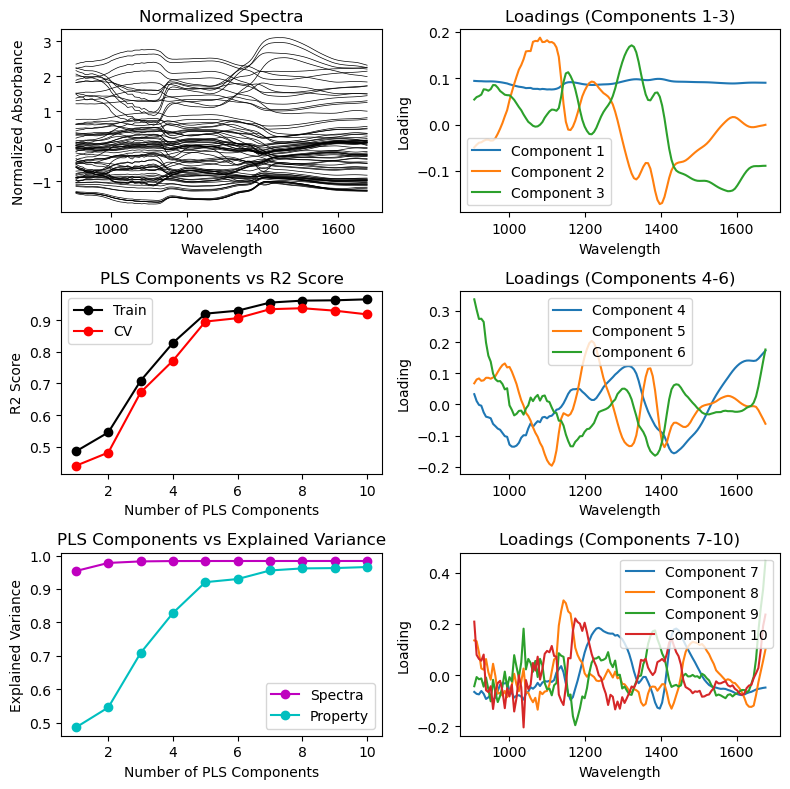

In [26]:
X_train, X_test, y_train, y_test = train_test_split(spectra, prop["mc"], test_size=0.2, random_state=2)
result=pls_cv_check(X_train, y_train, n_folds=5, max_components=10, scaleset=True)

### <span style="color: blue; ">テストセットへのモデル適応</span> 

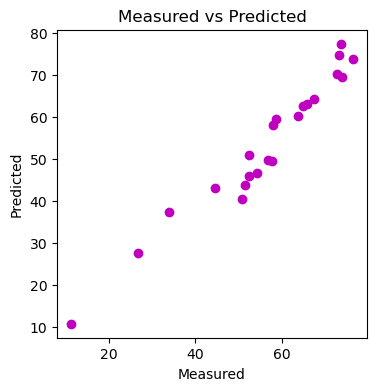

R²: 0.913


In [27]:
#最適成分でインスタンスを作成
pls = PLSRegression(n_components=result["optimal_n_components"], scale=True)
pls.fit(X_train,y_train)
y_pred = pls.predict(X_test)
# 横軸実測値y_test、縦軸予測値の散布図を作成
plt.figure(figsize=(4, 4))
plt.scatter(y_test, y_pred,c='m',label='opt')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Measured vs Predicted')
plt.show()
# 決定係数（R²）を計算
r2 = r2_score(y_test, y_pred)
print('R²:', np.round(r2,3))

### <span style="color: blue; ">モデル保存と呼びだし</span> 

In [28]:
# モデルをpickle形式で保存
with open('pls_model.pkl', 'wb') as file:
    pickle.dump(pls, file)

In [29]:
# モデルを読み込む
with open('pls_model.pkl', 'rb') as file:
    loaded_pls = pickle.load(file)
loaded_y_pred = loaded_pls.predict(X_test)

### <span style="color:DeepPink; ">7.12 GridSearchCVによるクロスバリデーション</span> 

Best PLS components: 8
Best SVR parameters: {'C': 100, 'gamma': 1}
PLS R²: 0.9133610015099756, MSE: 21.88882724446954
SVR R²: 0.8191319809330573, MSE: 45.6952283891136


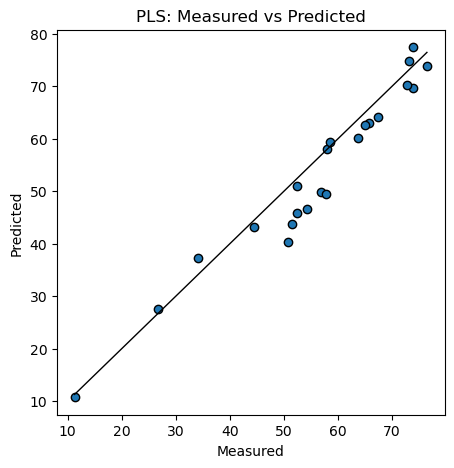

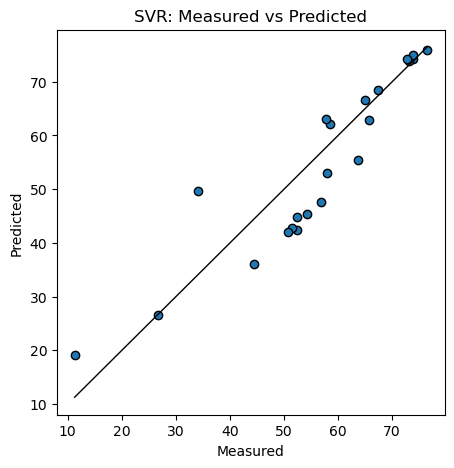

In [30]:
# ①PLSのグリッドサーチ
pls_params = {'n_components': list(range(1, 16))}#①-1 ハイパーパラメーターを設定
pls_grid = GridSearchCV(PLSRegression(), param_grid=pls_params, cv=5, scoring='r2')#①-2 インスタンス作成
pls_grid.fit(X_train, y_train)#①-3 fitメソッド
print(f"Best PLS components: {pls_grid.best_params_['n_components']}")

# ②SVRのグリッドサーチ
svr_params = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 1]
}
svr_grid = GridSearchCV(SVR(kernel='rbf'), param_grid=svr_params, cv=5, scoring='r2')
svr_grid.fit(X_train, y_train)
print(f"Best SVR parameters: {svr_grid.best_params_}")

#③最適化されたモデルでテストセットの予測
pls_predicted = pls_grid.predict(X_test)
svr_predicted = svr_grid.predict(X_test)

# PLSの性能評価
pls_r2 = r2_score(y_test, pls_predicted)
pls_mse = mean_squared_error(y_test, pls_predicted)
print(f'PLS R²: {pls_r2}, MSE: {pls_mse}')

# SVRの性能評価
svr_r2 = r2_score(y_test, svr_predicted)
svr_mse = mean_squared_error(y_test, svr_predicted)
print(f'SVR R²: {svr_r2}, MSE: {svr_mse}')

# PLSの散布図
plt.figure(figsize=(5, 5))
plt.scatter(y_test, pls_predicted, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=1)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('PLS: Measured vs Predicted')
plt.show()

# SVRの散布図
plt.figure(figsize=(5,5))
plt.scatter(y_test, svr_predicted, edgecolors=(0, 0, 0))
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=1)
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('SVR: Measured vs Predicted')
plt.show()

### <span style="color:DeepPink; ">7.13 pipelineを用いたモデルの最適化</span> 

### <span style="color: blue; ">スムージング数による予測の変化</span> 

In [31]:
# ①Savitzky-Golayフィルターで微分スペクトルを計算
def differentiate_spectra(spectra, order, window_length):
    return savgol_filter(spectra, window_length=window_length, polyorder=2, deriv=order)

# ②微分スペクトルの作成
X_train_1st_derivative = [differentiate_spectra(X_train, order=1, window_length=i) for i in range(3, 14, 2)]
X_train_2nd_derivative = [differentiate_spectra(X_train, order=2, window_length=i) for i in range(3, 14, 2)]

# ③PLSモデルの最適成分数を決定し、クロスバリデーションで評価
def optimize_pls(X, y, max_components=15):
    pls_params = {'n_components': range(1, max_components + 1)}
    pls_grid = GridSearchCV(PLSRegression(scale=True), param_grid=pls_params, cv=5, scoring='r2')
    pls_grid.fit(X, y)
    return pls_grid.best_estimator_, pls_grid.best_score_

# ④元のスペクトルと微分スペクトルでPLSモデルを最適化
models = [optimize_pls(X_train, y_train)] + [optimize_pls(X, y_train) for X in X_train_1st_derivative] + [optimize_pls(X, y_train) for X in X_train_2nd_derivative]

# 結果の表示
results = pd.DataFrame({
    'Model': ['Original'] + [f'1st Derivative (window={i})' for i in range(3, 14, 2)] + [f'2nd Derivative (window={i})' for i in range(3, 14, 2)],
    'Optimal Components': [model[0].n_components for model in models],
    'R² (CV)': [model[1] for model in models]
})
print(results)

                         Model  Optimal Components   R² (CV)
0                     Original                   8  0.937420
1    1st Derivative (window=3)                  10  0.943826
2    1st Derivative (window=5)                   9  0.943596
3    1st Derivative (window=7)                  11  0.940646
4    1st Derivative (window=9)                  12  0.935488
5   1st Derivative (window=11)                   8  0.935511
6   1st Derivative (window=13)                   8  0.937426
7    2nd Derivative (window=3)                   7  0.906911
8    2nd Derivative (window=5)                   8  0.932059
9    2nd Derivative (window=7)                   8  0.938918
10   2nd Derivative (window=9)                   8  0.938163
11  2nd Derivative (window=11)                   8  0.940588
12  2nd Derivative (window=13)                   8  0.939599


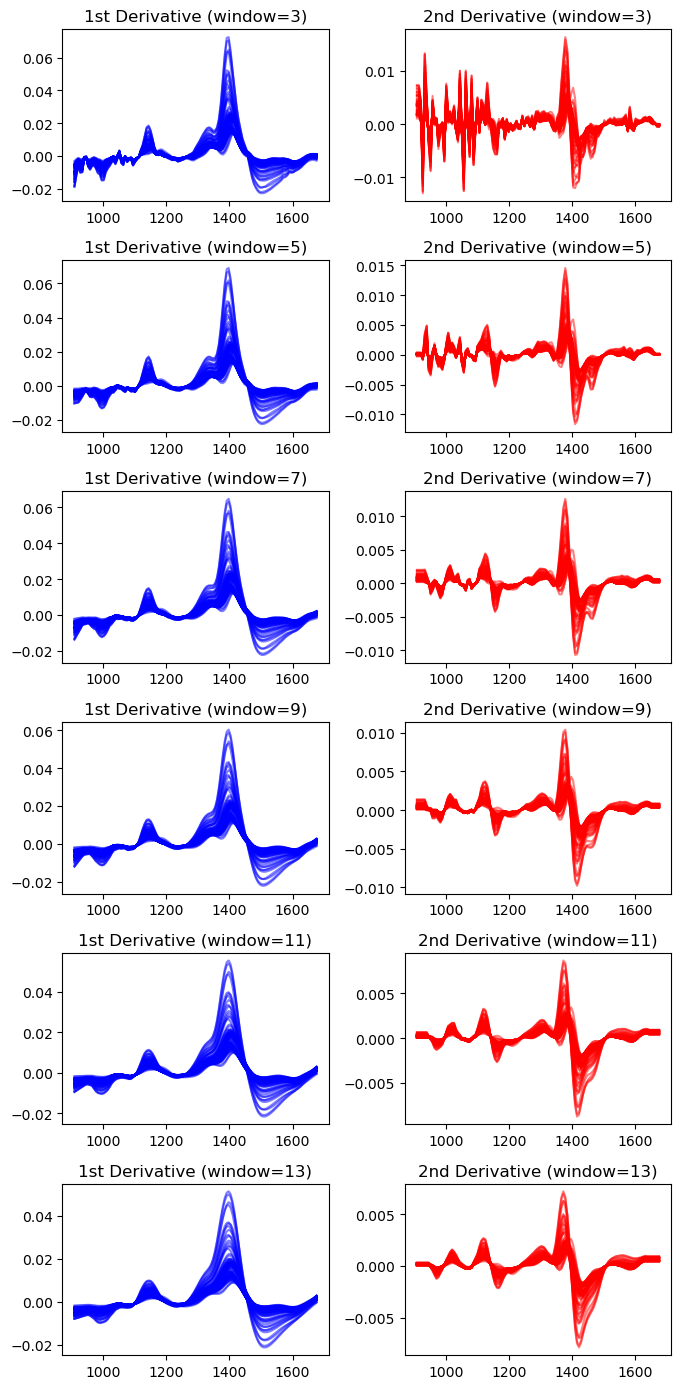

In [32]:
fig, axes = plt.subplots(6, 2, figsize=(7,14))
for i, (X_1st, X_2nd) in enumerate(zip(X_train_1st_derivative, X_train_2nd_derivative)):
    axes[i, 0].plot(X_train.columns,X_1st.T, color='blue', alpha=0.5)
    axes[i, 0].set_title(f'1st Derivative (window={3 + 2*i})')
    axes[i, 1].plot(X_train.columns,X_2nd.T, color='red', alpha=0.5)
    axes[i, 1].set_title(f'2nd Derivative (window={3 + 2*i})')
plt.tight_layout()
plt.show()

### <span style="color: blue; ">pipelineによるPCR</span>

In [33]:
# パイプラインの定義
pipeline = Pipeline([
    ('smoothing', FunctionTransformer(savgol_filter, kw_args={'window_length': 5, 'polyorder': 2})),
    ('pca', PCA()),
    ('regression', LinearRegression())
])

In [34]:
# パラメータグリッドの定義
param_grid = {
    'smoothing__kw_args': [{'window_length': w, 'polyorder': 2} for w in [5, 7, 9]],
    'pca__n_components': range(1, 16),
}

# GridSearchCVのインスタンス作成
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')

# グリッドサーチの実行
grid_search.fit(X_train, y_train)

# 最適なパラメータの表示
print("Best parameters:")
print(grid_search.best_params_)

# 最適なモデルのスコアの表示
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

Best parameters:
{'pca__n_components': 10, 'smoothing__kw_args': {'window_length': 9, 'polyorder': 2}}
Best cross-validation score: 0.94


In [35]:
#最適化されたモデルでテストセットの予測
predicted = grid_search.predict(X_test)
# 性能評価
r2_predicted= r2_score(y_test, predicted)
mse_predicted = mean_squared_error(y_test,predicted)
print(f'PLS R²: {pls_r2}, MSE: {pls_mse}')

PLS R²: 0.9133610015099756, MSE: 21.88882724446954


### <span style="color: blue; ">pipelineによるアルゴリズム比較</span>

In [36]:
# パイプラインの定義
pipelines = {
    'PCR': Pipeline([
        ('pca', PCA()),
        ('regressor', LinearRegression())
    ]),
    'PLS': Pipeline([
        ('regressor', PLSRegression())
    ]),
    'SVR': Pipeline([
        ('regressor', SVR())
    ]),
    'RandomForest': Pipeline([
        ('regressor', RandomForestRegressor())
    ]),
    'GradientBoosting': Pipeline([
        ('regressor', GradientBoostingRegressor())
    ]),
    'XGB': Pipeline([
        ('regressor', XGBRegressor())
    ])
}

# ハイパーパラメータの設定
param_grids = {
    'PCR': {'pca__n_components': range(1, 11)},
    'PLS': {'regressor__n_components': range(1, 11)},
    'SVR': {'regressor__C': [0.1, 1, 10], 'regressor__gamma': ['scale', 'auto']},
    'RandomForest': {'regressor__n_estimators': [10, 50, 100], 'regressor__max_depth': [None, 5, 10]},
    'GradientBoosting': {'regressor__n_estimators': [100, 200], 'regressor__learning_rate': [0.01, 0.1]},
    'XGB': {'regressor__n_estimators': [100, 200], 'regressor__learning_rate': [0.01, 0.1]}
}

# 各パイプラインに対してGridSearchCVを実行
results = {}
for name, pipeline in pipelines.items():
    grid = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='r2')
    grid.fit(X_train, y_train)
    results[name] = {
        'Best Parameters': grid.best_params_,
        'Best Score': grid.best_score_
    }

# 結果の表示
for name, result in results.items():
    print(f'{name}:')
    print(f'Best Parameters: {result["Best Parameters"]}')
    print(f'Best Score: {result["Best Score"]}\n')


PCR:
Best Parameters: {'pca__n_components': 10}
Best Score: 0.9427659824742198

PLS:
Best Parameters: {'regressor__n_components': 8}
Best Score: 0.9374201023470459

SVR:
Best Parameters: {'regressor__C': 10, 'regressor__gamma': 'scale'}
Best Score: 0.47145347330949566

RandomForest:
Best Parameters: {'regressor__max_depth': None, 'regressor__n_estimators': 50}
Best Score: 0.5791924139891316

GradientBoosting:
Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 100}
Best Score: 0.6750816824137859

XGB:
Best Parameters: {'regressor__learning_rate': 0.1, 'regressor__n_estimators': 200}
Best Score: 0.5822091419463662



### <span style="color: blue; ">PCAとSVM_ローディング・スコアの観察</span>

In [37]:
X_train, X_test, y_train, y_test = train_test_split(spectra, prop, test_size=0.3, random_state=2)
# パイプラインの定義
pipeline = Pipeline([
    ('pca', PCA()),
    ('svm', SVC())
])
# ハイパーパラメータのグリッド
param_grid = {
    'pca__n_components': range(1, 11),
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': [0.001, 0.01, 0.1, 1]
}
# GridSearchCVの設定
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

# グリッドサーチの実行
grid_search.fit(X_train, y_train["label"])

# 最適なパラメータとスコアの表示
print("Best parameters:")
print(grid_search.best_params_)
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))

# テストデータでの性能評価
y_pred = grid_search.predict(X_test)
print(classification_report(y_test["label"], y_pred))

Best parameters:
{'pca__n_components': 3, 'svm__C': 100, 'svm__gamma': 0.1}
Best cross-validation score: 0.99
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        19
           1       0.87      1.00      0.93        13

    accuracy                           0.94        32
   macro avg       0.93      0.95      0.94        32
weighted avg       0.95      0.94      0.94        32



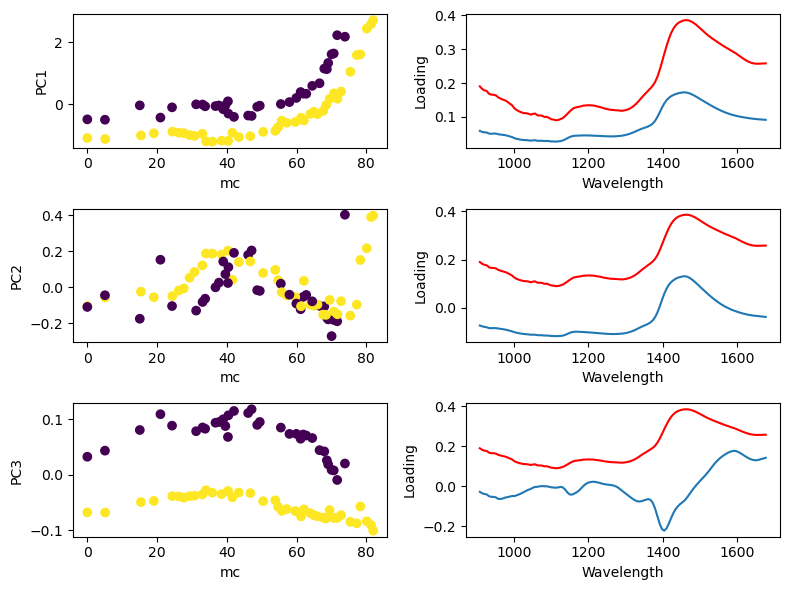

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

# 最適なパラメータでPCAとSVMを設定
pca = PCA(n_components=3)
svm = SVC(C=100, gamma=0.1, probability=True)

# PCAで変換
X_train_pca = pca.fit_transform(X_train)

# 新たな図でスコアとローディングのプロット
fig, axes = plt.subplots(3, 2, figsize=(8, 6))
mean_spectrum = X_train.mean(axis=0)
# スコアプロット
for i in range(3):
    axes[i, 0].scatter(y_train["mc"], X_train_pca[:, i], c=y_train["label"])
    axes[i, 0].set_xlabel('mc')
    axes[i, 0].set_ylabel(f'PC{i+1}')

# ローディングプロット
for i in range(3):
    axes[i, 1].plot(X_train.columns,pca.components_[i], label=f'PC{i+1}')
    axes[i, 1].plot(X_train.columns,mean_spectrum.values, color='r', label='Mean Spectrum')
    axes[i, 1].set_xlabel('Wavelength')
    axes[i, 1].set_ylabel('Loading')
plt.tight_layout()
plt.show()

In [39]:
# PCAで変換
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# PC1とPC2を使用
svm.fit(X_train_pca[:, [0, 1]], y_train["label"])
y_pred_12 = svm.predict(X_test_pca[:, [0, 1]])
print("Using PC1 and PC2:")
print(classification_report(y_test["label"], y_pred_12))

# PC2とPC3を使用
svm.fit(X_train_pca[:, [1, 2]], y_train["label"])
y_pred_23 = svm.predict(X_test_pca[:, [1, 2]])
print("Using PC1 and PC2:")
print(classification_report(y_test["label"], y_pred_23))
# PC1とPC3を使用
svm.fit(X_train_pca[:, [0, 2]], y_train["label"])
y_pred_13 = svm.predict(X_test_pca[:, [0, 2]])
print("Using PC1 and PC2:")
print(classification_report(y_test["label"], y_pred_13))

Using PC1 and PC2:
              precision    recall  f1-score   support

           0       0.86      0.95      0.90        19
           1       0.91      0.77      0.83        13

    accuracy                           0.88        32
   macro avg       0.88      0.86      0.87        32
weighted avg       0.88      0.88      0.87        32

Using PC1 and PC2:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        19
           1       0.81      1.00      0.90        13

    accuracy                           0.91        32
   macro avg       0.91      0.92      0.91        32
weighted avg       0.92      0.91      0.91        32

Using PC1 and PC2:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        13

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg     